In [0]:
#required imports
import numpy as np
import pandas as pd
import matplotlib as mlt
import tensorflow as tf
import os
import pathlib
import keras
from keras import regularizers
from keras.models import Model
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense, Input
from keras.layers import Activation, ZeroPadding2D, Lambda,Concatenate
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import h5py
from keras.utils import layer_utils

In [0]:
!pip3 install medpy

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#loading the model
from keras.models import model_from_json
json_file = open('/content/gdrive/My Drive/inputone/inputmodel.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("/content/gdrive/My Drive/inputone/inputwts.h5")

In [0]:
#we have to re-train only the last output layer
for layer in loaded_model.layers[:-1]:
    layer.trainable=False
loaded_model.layers[-1].trainable=True

In [0]:
#to check whether the initial layers are frozen
loaded_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 65, 65, 4)    0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 59, 59, 64)   12608       input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 59, 59, 64)   12608       input_3[0][0]                    
__________________________________________________________________________________________________
maximum_7 (Maximum)             (None, 59, 59, 64)   0           conv2d_15[0][0]                  
                                                                 conv2d_16[0][0]            

In [0]:
'''The same function as the one included in first training phase notebook'''
from sklearn.preprocessing import normalize
from PIL import Image
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from medpy.io import load, save
def gen_image(path1, path2, path3,path4,gtpath):   
  image_t1, image_header1 = load(path2)
  image_t2, image_header2 =load(path4)
  image_t1c, image_header1c =load(path3)
  image_flair, image_headerr =load(path1)
  image_gt, image_header_gt = load(gtpath)
  t1x, t1y, t1z = image_t1.shape
  final = np.zeros((155, 240, 240,4))
 
  for a in range(0, 155):
    imgt1 = image_t1[:,:,a]
    imgt1 = normalize(imgt1)
    imgt2 = image_t2[:,:,a]
    imgt2 = normalize(imgt2)
    imgt1c = image_t1c[:,:,a]
    imgt1c = normalize(imgt1c)
    imgtflair = image_flair[:,:,a]
    imgtflair = normalize(imgtflair)
    
    final[a] = np.dstack([imgt1, imgt2, imgt1c, imgtflair])
 

  
  return final, image_gt

In [0]:
'''Similar to the create_patch function in the first training phase notebook. However, the input patches are created according to natural frequency'''
def create_patch(array, gt,slice_number):
    patches65=[]
    patches33=[]
    slice = slice_number
    #gt_pixel = np.zeros(5580, dtype=int)
    gt1=np.zeros((12100,1,1,5))
    actual_gt=np.zeros(12100,dtype=int)
    
    k=0
    
   
    l=30
    for i in range(0,110):
      m=30
      for j in range(0,110):
              

              
        patch=array[slice,l:l+65,m:m+65,:]
        s_patch=patch[16:49,16:49,:]
        patches65.append(patch)
        patches33.append(s_patch)
        key=gt[l+32,m+32,slice]
        gt1[k,0,0,key]=1
        actual_gt[k]=key
             
              
        k=k+1
              
        m=m+1
      l=l+1
    
    
    return patches65, patches33, gt1, actual_gt

In [0]:
'''The second phase training. The final layer is re-trained as per the natural frequency of the all the classes. Change the path according to the need'''
from sklearn.utils import class_weight
from keras import backend as K
smooth=1
#path = '/content/gdrive/My Drive/NNFL Assignment/BRATS 2015 Dataset/Training'
path='/content/gdrive/My Drive/Training'
#path='/content/gdrive/My Drive/BRATS2015_Training'
j=0
i=0
with os.scandir(path) as training:
    for folder1 in training:
        path1 = path + '//' + folder1.name
        with os.scandir(path1) as lgg_hgg:
            for folder2 in lgg_hgg:
                path2 = path1 + '//' + folder2.name
                with os.scandir(path2) as brats:
                    modularity_path = []
                    for folder3 in brats:          
                        path3 = path2 + '/' + folder3.name
                        with os.scandir(path3) as vsdbrain:
                            for file in vsdbrain:
                                if file.name.endswith('mha'):
                                    path4 = path3 + '/' + file.name
                                    modularity_path.append(path4)      
                
                sorted_path = sorted(modularity_path)
                arr, gt= gen_image(sorted_path[0], sorted_path[1], sorted_path[2], sorted_path[3], sorted_path[4])
                for s in range(60,80):
                  patches65, patches33, gt_pixel, actual_gt = create_patch(arr, gt,s)
                  class_weights = class_weights = class_weight.compute_class_weight('balanced',np.unique(actual_gt),actual_gt)                      
                  sgd = keras.optimizers.SGD(learning_rate=0.005, momentum=0.5, nesterov=False)
                  loaded_model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy',tf.keras.metrics.Precision(class_id=0, name = 'normal_tissue_precision'),tf.keras.metrics.Precision(class_id=1, name = 'nec_precision'),tf.keras.metrics.Precision(class_id=2,name = 'edema_precision'),tf.keras.metrics.Precision(class_id=3,name = 'non_enhancing_tumor_precision'),tf.keras.metrics.Precision(class_id=4,name = 'enhancing_tumor_precision'),tf.keras.metrics.Recall(class_id=0,name = 'normal_tissue_recall'),tf.keras.metrics.Recall(class_id=2,name = 'edema_recall'),tf.keras.metrics.Recall(class_id=3,name = 'non_enhancing_tumor_recall'),tf.keras.metrics.Recall(class_id=4,name = 'enhancing_tumor_recall')])
                  loaded_model.fit([patches65, patches33],gt_pixel,epochs=1, class_weight=class_weights)
              
                model_json = loaded_model.to_json()
                with open("/content/gdrive/My Drive/inputone/inputre.json","w") as json_file:
                  json_file.write(model_json)
                loaded_model.save_weights("/content/gdrive/My Drive/inputone/inputweightre.h5")
                print("Saved model to disk")
                  
                  
                  

In [0]:
#loading the model for evaluation
from keras.models import model_from_json
json_file = open('/content/gdrive/My Drive/inputone/inputre.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("/content/gdrive/My Drive/inputone/inputweightre.h5")

In [0]:
#creates a patch for image segmentation of the model.
def create_test_patch(array, gt,slice_number):
    patches65=[]
    patches33=[]
    slice = slice_number
    
    gt1=np.zeros((10000,1,1,5))
    actual_gt=np.zeros(10000,dtype=int)
    k=0
    l=30
    for i in range(0,100):
      m=30
      for j in range(0,100):
              

              
        patch=array[slice,l:l+65,m:m+65,:]
        s_patch=patch[16:49,16:49,:]
        patches65.append(patch)
        patches33.append(s_patch)
        key=gt[l+32,m+32,slice]
        gt1[k,0,0,key]=1
        actual_gt[k]=key
             
              
        k=k+1
              
        m=m+1
      l=l+1
    return patches65, patches33, gt1, actual_gt

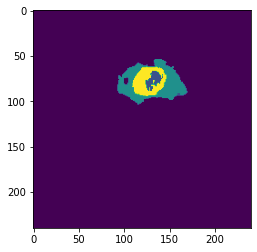

(10000, 1, 1, 5)


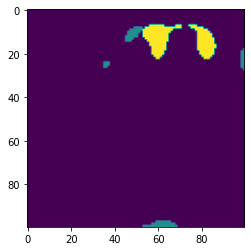

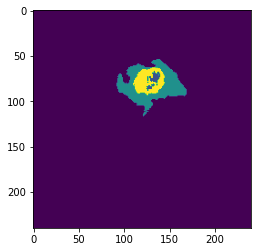

(10000, 1, 1, 5)


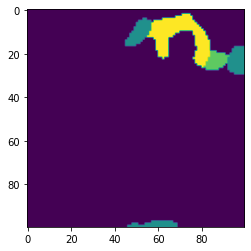

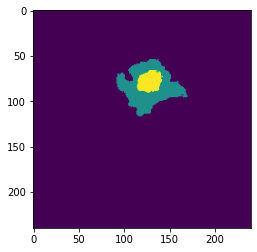

(10000, 1, 1, 5)


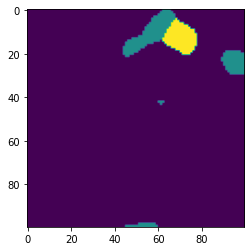

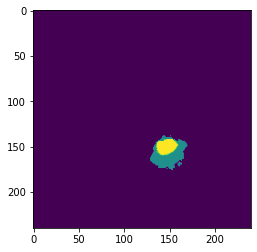

(10000, 1, 1, 5)


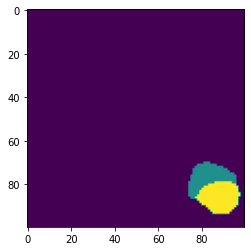

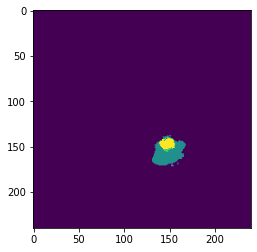

(10000, 1, 1, 5)


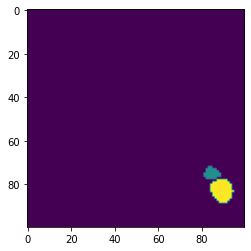

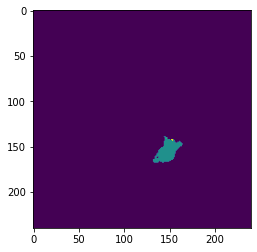

(10000, 1, 1, 5)


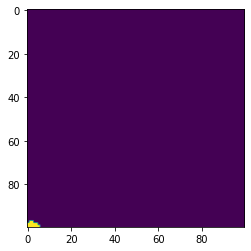

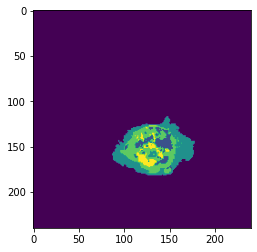

(10000, 1, 1, 5)


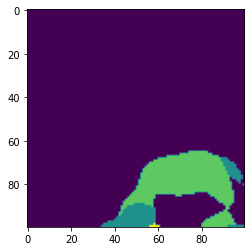

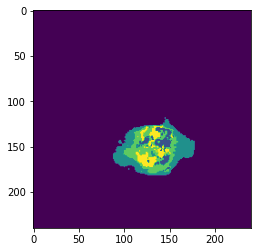

(10000, 1, 1, 5)


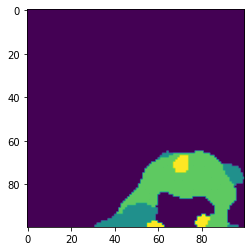

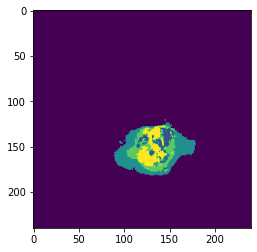

(10000, 1, 1, 5)


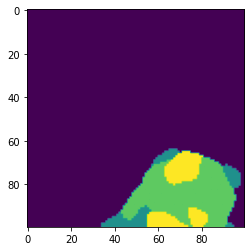

In [30]:
'''For viewing the segmented images in the training dataset. Mostly, slices 60-80 contain information about the tumors.
 Change the path as per the need. The dimension and scope of input image is different from ground truth due to memory problems'''
path = '/content/gdrive/My Drive/Testing'
import matplotlib.cm as cm
import matplotlib.pyplot as plt
j=0
i=0
with os.scandir(path) as training:
    for folder1 in training:
        path1 = path + '//' + folder1.name
        with os.scandir(path1) as lgg_hgg:
            for folder2 in lgg_hgg:
                path2 = path1 + '//' + folder2.name
                with os.scandir(path2) as brats:
                    modularity_path = []
                    for folder3 in brats:          
                        path3 = path2 + '/' + folder3.name
                        with os.scandir(path3) as vsdbrain:
                            for file in vsdbrain:
                                if file.name.endswith('mha'):
                                    path4 = path3 + '/' + file.name
                                    modularity_path.append(path4)      
                
                sorted_path = sorted(modularity_path)
                arr, gt= gen_image(sorted_path[0], sorted_path[1], sorted_path[2], sorted_path[3], sorted_path[4])
                image_t1, image_header1 = load(sorted_path[4])
                for slice in [70,72,75]:
                  ground = image_t1[:,:,slice]
                  plt.imshow(ground)
                  plt.show()
                  patches65, patches33, gt_pixel, actual_gt = create_test_patch(arr, gt,slice)
                  #prediction of the output
                  predict=loaded_model.predict(x=[patches65, patches33])
                  print(predict.shape)
                  #conversion of output from one-hot to integer
                  k = np.reshape(predict,(10000,5))
                  m = np.argmax(k,axis =1)
                  #reshaping the output to get a 2D image
                  final = np.reshape(m,(100,100))
                  plt.imshow(final)
                  plt.show() 

In [0]:
'''For calculating precision and recall for each class. Dice score is the HM of recall and precision. Hence it is not calculated separately
As of May 2020, evaluate() function gives the metrics for only one input and not for the whole dataset. 
As not all brains and not all the slices contain all kinds of tumor, precision and recall for some classes may come out to be zero due to lack of positive samples.
Change the path as per your need.'''
path = '/content/gdrive/My Drive/Testing_one_patch'

with os.scandir(path) as training:
    for folder1 in training:
        path1 = path + '//' + folder1.name
        with os.scandir(path1) as lgg_hgg:
            for folder2 in lgg_hgg:
                path2 = path1 + '//' + folder2.name
                with os.scandir(path2) as brats:
                    modularity_path = []
                    for folder3 in brats:          
                        path3 = path2 + '/' + folder3.name
                        with os.scandir(path3) as vsdbrain:
                            for file in vsdbrain:
                                if file.name.endswith('mha'):
                                    path4 = path3 + '/' + file.name
                                    modularity_path.append(path4)      
                
                sorted_path = sorted(modularity_path)
                arr, gt= gen_image(sorted_path[0], sorted_path[1], sorted_path[2], sorted_path[3], sorted_path[4])
                for s in range(74):
                  patches65, patches33, gt_pixel, actual_gt = create_patch(arr, gt,s)
                results=final_model.evaluate(x=[patches65, patches33],y=gt_pixel)
                  
                

In [0]:
print(results)

[1.055199195609605, 0.8695041537284851, 0.9569186568260193, 0.0, 0.6871324181556702, 0.5480849146842957, 0.8450714349746704, 0.9594215154647827, 0.0, 0.4855872094631195, 0.583855152130127, 0.37196657061576843]


Dice score is the harmonic mean of precision and recall. Hence, we calculated it manually.